In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

paths = ['I_V Sweep - Unit (transfer) [upper_tr(3) ; 2_5_2026 11_28_33 AM].csv']

for i in range(len(paths)):
    with open(paths[i], 'r', encoding = 'utf-8') as f:
        lines = f.readlines()
        for j, line in enumerate(lines):
            if line.startswith('DataValue')== True:
                skiprow_n = j - 1
                break


df = pd.read_csv('I_V Sweep - Unit (transfer) [lower_tr(4) ; 2_5_2026 11_32_31 AM].csv', sep = ',', skiprows = skiprow_n)

df.columns = df.columns.str.strip()
df['VD'] = df['VD'].round(3)

df['ID'] = df['ID'].abs()

Text(0.5, 1.0, 'transfer curve')

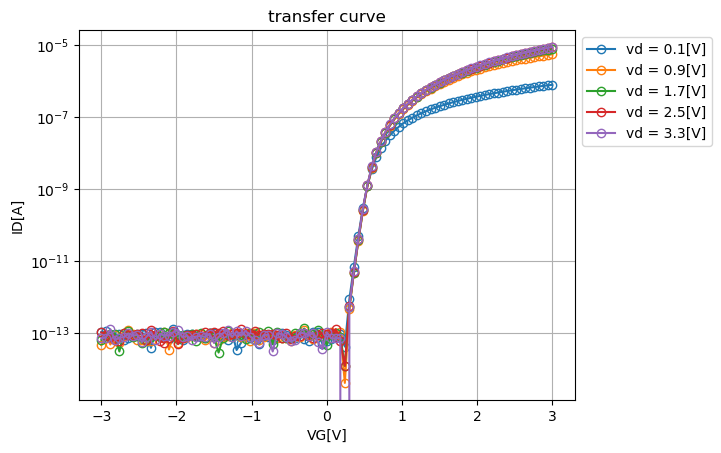

In [3]:
fig, ax = plt.subplots()

group=df.groupby('VD')
for i, g in group:
    plt.semilogy(g['VG'],g['ID'],marker = 'o',markerfacecolor = 'none',label =  f'vd = {i}[V]')

ax.legend(bbox_to_anchor = (1,1))
ax.grid(True)
ax.set_xlabel('VG[V]')
ax.set_ylabel('ID[A]')
ax.set_title('transfer curve')


In [4]:
target1 = -10                               # log(ID) = -10이 타겟임(vth 산출용)
target2 = -9                                # SS 산출용
vth_by_vd_10 = {}  # VD별 Vth 저장
vth_by_vd_9 = {}  # VD별 Vth 저장
for vd, g in df.groupby('VD'):              # 앞에 있는 vd는 df.groupby('VD')의 key인 'VD'를 받는것이고 뒤에 있는 g는 key 'VD'에 해당하는 값을 받는다.
    g = g.sort_values('ID')

    VG = g['VG'].to_numpy()                 # VG column을 숫자로 변환
    ID = g['ID'].to_numpy()                 # ID column을 숫자로 변환

    # log10(|ID|) 계산: 0은 로그 불가 → 아주 작은 값으로 클리핑
    absID = np.abs(ID)
    absID = np.clip(absID, 1e-300, None)   # underflow 방지
    logI = np.log10(absID)

     # ===== 3) target 교차 구간 탐색 + 선형 보간 =====
    diff1 = logI - target1
    diff2 = logI - target2
    cross_idx_10 = np.where(diff1[:-1] * diff1[1:] <= 0)[0]  # target을 사이에 두는 인접 점(★★★★★★★★★★★★ np.where(condition,True,False))
    cross_idx_9 = np.where(diff2[:-1] * diff2[1:] <= 0)[0] 

    if len(cross_idx_10) == 0:
        vth_by_vd_10[vd] = np.nan
        continue
    if len(cross_idx_9) == 0:
        vth_by_vd_9[vd] = np.nan
        continue
    # 첫 번째 crossing 사용 (원하면 마지막 crossing: cross_idx[-1])
    i1 = cross_idx_10[0]
    i2 = cross_idx_9[0]

    x0, x1 = VG[i1], VG[i1+1]
    y0, y1 = logI[i1], logI[i1+1]

    z0, z1 = VG[i2], VG[i2+1]
    t0, t1 = logI[i2], logI[i2+1]    

    # 분모 0 방지
    if y1 == y0:
        vth_10 = np.nan
    else:
        vth_10 = x0 + (target1 - y0) * (x1 - x0) / (y1 - y0)

    vth_by_vd_10[vd] = vth_10
    
    # 분모 0 방지
    if t1 == t0:
        vth_9 = np.nan
    else:
        vth_9 = z0 + (target2 - t0) * (z1 - z0) / (t1 - t0)

    vth_by_vd_9[vd] = vth_9
    
# ===== 5) VD별 Vth 출력 =====
print(f"Vth @ log10(|ID|) = {target1} (by VD)")
for vd in sorted(vth_by_vd_10.keys()):
    print(f"VD={vd}[V]: Vth={vth_by_vd_10[vd]:.2f}[V]")

    # ===== 6) VD별 SS 계산 =====
ss_by_vd = {}  # VD별 SS 저장 (mV/dec)

for vd in vth_by_vd_10.keys():
    vg_at_10 = vth_by_vd_10.get(vd, np.nan)  # log|ID|=-10에서 VG
    vg_at_9  = vth_by_vd_9.get(vd, np.nan)   # log|ID|=-9에서 VG

    # 둘 중 하나라도 NaN이면 SS도 NaN
    if np.isnan(vg_at_10) or np.isnan(vg_at_9):
        ss_by_vd[vd] = np.nan
    else:
        ss_v_per_dec = (vg_at_9 - vg_at_10) / (target2 - target1)  # 여기서는 /1이라 동일하지만 일반식으로 작성
        ss_by_vd[vd] = ss_v_per_dec * 1000  # mV/dec

# ===== 7) VD별 SS 출력 =====
print(f"SS (mV/dec) using log10(|ID|)={target1} to {target2} (by VD)")
for vd in sorted(ss_by_vd.keys()):
    print(f"VD={vd}[V]: SS={ss_by_vd[vd]:.2f}[mV/dec]")



Vth @ log10(|ID|) = -10 (by VD)
VD=0.1[V]: Vth=0.44[V]
VD=0.9[V]: Vth=0.45[V]
VD=1.7[V]: Vth=0.45[V]
VD=2.5[V]: Vth=0.45[V]
VD=3.3[V]: Vth=0.45[V]
SS (mV/dec) using log10(|ID|)=-10 to -9 (by VD)
VD=0.1[V]: SS=87.91[mV/dec]
VD=0.9[V]: SS=81.83[mV/dec]
VD=1.7[V]: SS=81.53[mV/dec]
VD=2.5[V]: SS=81.62[mV/dec]
VD=3.3[V]: SS=81.39[mV/dec]
